# Exam project: Scraping job postings from Jobindex

This notebook is used for webscraping www.jobindex.dk for all job postings in the period xxxx-2020. 

In [8]:
# Import necessary modules
import requests
from bs4 import BeautifulSoup
import numpy as np
import re

#Make log
import scraping_class
logfile = 'log_jobindex_scraping.txt'
connector = scraping_class.Connector(logfile)

#Define todays date
from datetime import date
today = date.today().strftime("%Y%m%d") # to get format 20080101

### Define the maximum page number to do a FOR loop through
Each page of www.jobindex.dk/jobsoegning contains 20 joblistings. Since the number of job postings differ from time to time, so does the number of pages. To be able to scrape job postings on all pages, we look at the pagination. The pagination looks as the picture below, and we want to save the number of the last page as "last_page" to be able to loop through it later on.  
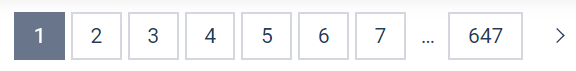

In [9]:
#Define the url and fetch the HTML using the requests module
url = 'https://www.jobindex.dk/jobsoegning?lang=da.html'
response = requests.get(url)  
html = response.text  
soup = BeautifulSoup(html,'lxml') # parse the raw html using BeautifoulSoup

#Find the pagination and extract the text-part of the pagination links, i.e. not the link but the page number. 
pagination = soup.find_all('a', {'class':'page-link'})
last_page = int(pagination[-1].text) #Save the last page number as "last page"
print(last_page)

656


### Extract all job postings from www.jobindex.dk. 
For each job posting one is redirected from www.jobindex.dk/jobsoegning to a separate www-webpage or PDF, that contains the full job posting. We therefore have to distinguish between these two.

In [10]:
import PyPDF2 
import textract
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import slate3k as slate
import pandas as pd

jobindex_links = []
for i in range(1,3): # NOTE I'm only testing it on the first two pages. Use last_page when ready
    url = f'https://www.jobindex.dk/jobsoegning?lang=da?page={i}.html'
    jobindex_links.append(url)   
#print(jobindex_links)
html = []
job_links = []
jobs = []
dates = []

for url in jobindex_links:
    response = requests.get(url)  
    html = response.text  
    soup = BeautifulSoup(html,'lxml')
    #one job result is given by class=jobsearch-result
    joblistings = soup.find_all('div',{'class':'jobsearch-result'})
    #print(joblistings)
    for joblisting in joblistings:
        title = re.findall(r'(?<=<b>)(.*)(?=</b>)', str(joblisting))[0]
        links = re.findall("href=[\"\'](.*?)[\"\']", str(joblisting))
        link = str(links[1])
        link = link.replace("&amp;", "&")
        pub_date = re.findall(r'time\sdatetime="(.*)"', str(joblisting))
        dates.append(pub_date) 
        job = [title,link,pub_date]
        jobs.append(job) # Jobs is a list of list where each list contains the title job, and the link for that job, this will help later
        job_links.append(link)

for i in range(len(job_links)):
    if 'pdf' in jobs[i][1]:
        #scraping a PDF file
        #request the url
        url = jobs[i][1]
        response = requests.get(url)
        #save the pdf in the current folder
        with open('pdf.pdf', 'wb') as f:
            f.write(response.content)
        #open the pdf and get the text in doc
        with open('pdf.pdf', 'rb') as fp:
            doc = slate.PDF(fp)
            doc = str(doc).replace('\n','')
            doc = str(doc).replace('\r','')
            jobs[i].append(doc)
    else:
        link = jobs[i][1]
        response = requests.get(link)
        html = response.text
        soup = BeautifulSoup(html, 'lxml')
        description = soup.get_text()
        description = description.replace('\n','')
        description = description.replace('\r','')
        jobs[i].append(description)
    
    print('Completed %d/%d job_links' % (i,len(job_links)))

#transforming into dataframe
df = pd.DataFrame(jobs)
df.columns = ["Job Title", "Link","Date", "Description",]


Completed 0/40 job_links
Completed 1/40 job_links
Completed 2/40 job_links
Completed 3/40 job_links
Completed 4/40 job_links
Completed 5/40 job_links
Completed 6/40 job_links
Completed 7/40 job_links
Completed 8/40 job_links
Completed 9/40 job_links
Completed 10/40 job_links
Completed 11/40 job_links
Completed 12/40 job_links
Completed 13/40 job_links
Completed 14/40 job_links
Completed 15/40 job_links
Completed 16/40 job_links
Completed 17/40 job_links
Completed 18/40 job_links
Completed 19/40 job_links
Completed 20/40 job_links
Completed 21/40 job_links
Completed 22/40 job_links
Completed 23/40 job_links
Completed 24/40 job_links
Completed 25/40 job_links
Completed 26/40 job_links
Completed 27/40 job_links
Completed 28/40 job_links
Completed 29/40 job_links
Completed 30/40 job_links
Completed 31/40 job_links
Completed 32/40 job_links
Completed 33/40 job_links
Completed 34/40 job_links
Completed 35/40 job_links
Completed 36/40 job_links
Completed 37/40 job_links
Completed 38/40 job_li

## Identifying jobs with possibility of working remotely

In [473]:
# First we define a list of keyword that we think a job posting where working remotely is a possibility will include

keywords = ['hjemmefra', 'arbejde hjemme', 'hjemmearbejde','hjemmekontor', 'arbejde hjemmefra', 'arbejde remote', 'fjernarbejde']

# I will now look for these words in the description column. I am not using the tokenized version of column because then I 
# can't look for expressions with more than one word. If you want to use the tokenized version then you have to use bigrams

df['Remote'] = '0'
for word in keywords:
    for i in range(len(df)):
        df['Description'][i] = str(df['Description'][i]).lower()
        if word in df['Description'][i]:
            df['Remote'][i] = '1'
            
        

## Identifying the most popular words in job descriptions

In [527]:
# The first step is to clean the job descriptions as much as possible so we can narrow down the words included for 
# analysis as much as possible

df['Tokenized_description'] = ' '
symbols = ['?','!','>','<','-','[',']','(',')','{','}',' –','``',"''",'""','\\','@','$','&','=']
for i in range(len(df)):
    stop_words = nltk.corpus.stopwords.words("danish")
    df['Tokenized_description'][i] = re.sub(r'(\.+ )|,|\||:|/|\'|\-|;|\*|!|(\s\d+\s)|(\s\W\s)',' ',str(df['Description'][i]))
    df['Tokenized_description'][i] = str(df['Tokenized_description'][i]).rstrip('\\')
    df['Tokenized_description'][i] = nltk.word_tokenize(str(df['Tokenized_description'][i].lower()))
    df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w in stop_words] 
    df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w in symbols]
    df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w.isnumeric()]
    df['Tokenized_description'][i] = [word for word in df['Tokenized_description'][i] if len(word) > 3]
    
# Finding intersections --- USELESS
df['description_set'] = df['Tokenized_description'].apply(set)
description_set = df['description_set'].tolist() #convert each description into a set 
set.intersection(*description_set)
del df['description_set']

# Finding most frequent words in all descriptions --- USELESS ATM BUT MAYBE IF WE CLEAN IT ENOUGH IT WILL WORK

descriptions_list = [] 
# This loop will pull all tokens in one bag
for i in range(len(df)):
    descriptions_list.extend(df['Tokenized_description'][i]) 
    
word_dist = nltk.FreqDist(descriptions_list) word_dist

In [ ]:
# CELL DEDICATED TO KEEP CLEANING DESCRIPTIONS

def clean(doc):
    #doc = doc.replace('\n','')
    #doc = doc.replace('\r','')
    doc = doc.replace('\t','')
    doc = doc.replace('\'','')
    doc = doc.replace('|','')
    doc = doc.replace('/','')

def strip_html(row):
    return str(html.fromstring(row).text_content())

from lxml import html
for row in df['Description']:
    strip_html(str(row))
    
    
    
#text = re.sub('<[^>]*>', '', text)
#emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)

## Assigning DISCO-08 codes to the job postings
This function will be used to assign a DISCO-08 code to the job postings. It goes through the following steps:

1. Importing a csv file downloaded from Danmarks Statistik which includes the different job functions that fall under each DISCO-08 category
2. Clean this csv file and converting it into a dataframe with two columns, one that has the disco codes and one that has a list of all the jobs that fall into each code
3. Tokenizing the jobs 
4. Tokenizing the words in the 'Job Title' column from our job postings data
5. Creating a function that compares the tokens in the job titles to the tokens in the DISCO dataframe and if a match is found, then returning the corresponding DISCO code

In [319]:
# Importing and cleaning DISCO-08 classification
import pandas as pd
import re
disco = pd.read_csv(r"C:\Users\lisbe\OneDrive\11. Semester\Social Data Science\Modules\csv_da.csv",header=None)
disco_clean = disco.copy()

# Remove words that start with lowercase
for i in range(len(disco_clean)):
    disco_clean[3][i] = ' '.join([word for word in str(disco_clean[3][i]).split(' ') if not word.islower()])

# Create a dictionary for DISCO functions

disco_clean['DISCO'] = disco_clean[0].astype(str).str[:1] #This column will have the highest hierarchy code 0-9
del disco_clean[0]
del disco_clean[1]
del disco_clean[2]
disco_clean = disco_clean.groupby(by=disco_clean['DISCO']).sum()
disco_clean.rename({3:'functions'}, axis='columns', inplace = True) # rename column 
for i in range(9): # Adding a space in between words that are missing them "LikeThis"
    disco_clean['DISCO'] = disco_clean['DISCO'].astype(str).str[:1] # We only want the first number 
    disco_clean['functions'][i] = re.sub(r"(\w)([A-Z])", r"\1 \2", str(disco_clean['functions'][i]))
    
disco_clean["functions_tokenized"] = ""
for i in range(len(disco_clean)):
    disco_clean['functions_tokenized'][i]=nltk.word_tokenize(str(disco_clean['functions'][i]).lower())
    
# Now I would like a job type column from the job titles where I would extract the nouns from job titles
#pip install afinn
import nltk
df['Job Title']=df['Job Title'].str.replace(',','')
df["tokenized_titles"] = ""
for i in range(len(df)):
    df['tokenized_titles'][i] = nltk.word_tokenize(str(df['Job Title'][i]).lower())

# This loop creates a new column in the df that assigns a disco code to each posting based on the words in the title

df['disco'] = ''
for m in range(len(df)):
    for i in range(len(disco_clean)):
        for element in disco_clean['functions_tokenized'][i]:
            if element in df['tokenized_titles'][m]:
                df['disco'][m] = disco_clean['DISCO'][i]

C:\Users\lisbe\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### Scrape the joblistings for each geographical area and job categories/industries
www.jobindex.dk/jobsoegning has a filter for geographical area and job category, respectively. These can be seen in the picture below. We will scrape this to be able to describe in which areas and industries remote working is especially taking place. The address of the company is also attached to the job posting, and even though this information would be more detailed, we have experienced that the address often belongs to the headquarter of the company and not the specific area, where the job is. Therefore we use the information from the geographical filter.
We will loop through the filters and extract job titles and company, which can then be merged onto the big dataframe.

In [112]:
import re
import requests
from datetime import date
from bs4 import BeautifulSoup
import numpy as np

#Define the basic url
url = 'https://www.jobindex.dk/jobsoegning'
response = requests.get(url)
html = response.text
soup = BeautifulSoup(html,'lxml')

#Areas are given in the html by div id=areas and class=area_label
areas_html = soup.find('div', {'id':'areas'})#('a', {'class':'area_label'})
areas_div = str(areas_html).split('href="/jobsoegning/')[1:]

#Find the names of each of the areas
areas = ()
areas_delete = ('skaane', 'faeroeerne', 'udlandet', 'groenland', 'danmark') #delete regions outside Denmark's borders
for area in areas_div:
    link = area.split('"')[0]
    if link in areas_delete:
        del link
    else:
        areas += (link,)
areas += ('danmark',) #make sure Danmark is the last element in the tuple, since it is ordered. 
#print(areas)

#Categories are given in the html by and id=categories
cat_html = soup.find('div', {'id':'categories'})
cat_div = soup.find_all('a',{'class':'filter-section-header title collapsed'}) #the filter collapses

categories = []
subcategories = []
for cat in cat_div:
    #first find the overall categories
    cat_name = re.findall(r'(?<=<span>)(.*)(?=<span class)', str(cat))[0]
    cat_name = cat_name.replace('\xad','')
    cat_links = re.findall("href=[\"\'](.*?)[\"\']", str(cat))
    cat_id = str(cat_links[0])
    cat_id = cat_id.replace('#','')
    category = [cat_name,cat_id]
    categories.append(category)
    #next find the sub-categories
    subcat_div = str(cat_html).split('href="/jobsoegning/')[1:]
for subcat in subcat_div:
    subcategory = subcat.split('"')[0]
    #cat_id = re.findall('(.*?)/', str(subcategory))
    #subcat_done = [subcategory,cat_id]
    subcategories.append(subcategory)
#print(categories)
#print(subcategories)
    

In [ ]:
import math
import time
import requests
from bs4 import BeautifulSoup
import numpy as np
import re

#Scraping the areas and categories from jobindex.
quarters = [['0101','0331'],['0401','0630'],['0701','0930'],['1001','1231']]
years = ['18','19','20']

filter_jobs = []
#Loop through all areas and subcategories
for q in quarters: #Loop through each quarter
    for y in years: #Loop through each year
        for area in areas:
            for subcategory in subcategories:
                print('Now requesting url: ' + subcategory +' and '+ area)
                url = f'https://www.jobindex.dk/jobsoegning/{subcategory}/{area}?jobage=archive&maxdate=20{y}{q[1]}&mindate=20{y}{q[0]}'
                response = requests.get(url) 
                soup = BeautifulSoup(response.text,'lxml')
        
                #Identify total number of job postings in the given quarter
                pages = BeautifulSoup(str(soup.find_all("div", {'class':'jix_pagination_total'}))).get_text() 
                total = re.findall(r'af(?s)(.*)resultat',str(pages))
                total = str(total).strip("[]").strip("''").strip().replace('.','')
                if total == 0:
                    continue
                #Use total number of job postings to calculate total number of pages
                last_page = math.ceil(int(total)/20)
        
                #Loop through pages
                for page in range(1,last_page+1):
                    if  page % 20 == 0:
                        print('Now scraping page: ',page,'/', last_page, ' for ', subcategory, ' and ', area)
                    url = f'https://www.jobindex.dk/jobsoegning/{subcategory}/{area}?jobage=archive&maxdate=20{y}{q[1]}&mindate=20{y}{q[0]}&page={page}'
                    response = requests.get(url)  
                    html = response.text   
                    if '<strong>' in html: 
                        html = html.replace('<strong>','<b>')\
                                    .replace('</strong>','</b>')
                    else:
                        print('No <strong>')
                    soup = BeautifulSoup(html,'lxml') 
                    joblistings = soup.find_all('div',{'class':'jobsearch-result'}) 
                        
                    for joblisting in joblistings: #Loop through job listings
                        #Find title"
                        title = re.findall(r'<b>(.*?)</b>', str(joblisting))[0]
                        if 'amp;' in title:
                            title = title.replace('amp;','')
                        #Find company name
                        if len(re.findall(r'<b>(.*?)</b>', str(joblisting)))>1:
                            company = re.findall(r'<b>(.*?)</b>', str(joblisting))[1]
                            if 'amp;' in company:
                                company = company.replace('amp;','') 
                        #Find publication date
                        pub_date = re.findall(r'time\sdatetime="(.*)"', str(joblisting))[0]
                        geo_area = area #Save geographical area
                        cat_id = re.findall('(.*?)/', str(subcategory))[0] #Save category 
                        subcat_id = subcategory #Save subcategory
                        #Find link to job posting
                        descrip = BeautifulSoup(str(joblisting), 'lxml')
                        for div in descrip.find_all("div", {'class':'jix_toolbar jix_appetizer_toolbar'}): # remove toolbar at the end of each job
                            div.decompose()
                        for span in descrip.find_all("span", {'class':'jix_toolbar jix_appetizer_toolbar'}): # remove toolbar at the end of each job
                            span.decompose()
                        links = re.findall("href=[\"\'](.*?)[\"\']", str(descrip))
                        if len(links)>1:
                            link = str(links[1])
                        else:
                            link = str(links[0])
                        link = link.replace("&amp;", "&")
                        # Indirectly extracting the short job description by removing everything else
                        descrip = descrip.get_text()
                        descrip = descrip.replace("\n", " ") # remove \n
                        job = [title, company, pub_date, geo_area, cat_id, subcat_id, link, descrip]
                        filter_jobs.append(job)
    print('Finished',q,'of year 20',y) 

Now requesting url: it/database and storkoebenhavn
Now scraping page:  20 / 26  for  it/database  and  storkoebenhavn
Now requesting url: it/itdrift and storkoebenhavn
Now scraping page:  20 / 36  for  it/itdrift  and  storkoebenhavn
Now requesting url: it/itkurser and storkoebenhavn
Now requesting url: it/itledelse and storkoebenhavn
Now scraping page:  20 / 26  for  it/itledelse  and  storkoebenhavn
Now requesting url: it/internet and storkoebenhavn
Now scraping page:  20 / 23  for  it/internet  and  storkoebenhavn
Now requesting url: it/systemudvikling and storkoebenhavn
Now scraping page:  20 / 89  for  it/systemudvikling  and  storkoebenhavn
Now scraping page:  40 / 89  for  it/systemudvikling  and  storkoebenhavn
Now scraping page:  60 / 89  for  it/systemudvikling  and  storkoebenhavn
Now scraping page:  80 / 89  for  it/systemudvikling  and  storkoebenhavn
Now requesting url: it/telekom and storkoebenhavn
Now requesting url: it/virksomhedssystemer and storkoebenhavn
Now scrapin

Now requesting url: social/laege and storkoebenhavn
Now requesting url: social/laegesekretaer and storkoebenhavn
Now requesting url: kontor/offentlig and storkoebenhavn
Now scraping page:  20 / 38  for  kontor/offentlig  and  storkoebenhavn
Now requesting url: social/pleje and storkoebenhavn
Now scraping page:  20 / 70  for  social/pleje  and  storkoebenhavn
Now scraping page:  40 / 70  for  social/pleje  and  storkoebenhavn
Now scraping page:  60 / 70  for  social/pleje  and  storkoebenhavn
Now requesting url: social/psykologi and storkoebenhavn
Now requesting url: social/socialraadgivning and storkoebenhavn
Now requesting url: social/sygeplejerske and storkoebenhavn
Now scraping page:  20 / 40  for  social/sygeplejerske  and  storkoebenhavn
Now scraping page:  40 / 40  for  social/sygeplejerske  and  storkoebenhavn
Now requesting url: social/tandlaege and storkoebenhavn
Now requesting url: social/teknisksundhed and storkoebenhavn
Now requesting url: social/terapi and storkoebenhavn
N

Now requesting url: it/itkurser and region-sjaelland
Now requesting url: it/itledelse and region-sjaelland
Now requesting url: it/internet and region-sjaelland
Now requesting url: it/systemudvikling and region-sjaelland
Now requesting url: it/telekom and region-sjaelland
Now requesting url: it/virksomhedssystemer and region-sjaelland
Now requesting url: ingenioer/byggeteknik and region-sjaelland
Now requesting url: ingenioer/elektronik and region-sjaelland
Now requesting url: ingenioer/kemi and region-sjaelland
Now requesting url: ingenioer/teknikledelse and region-sjaelland
Now requesting url: ingenioer/maskiningenioer and region-sjaelland
Now requesting url: ingenioer/medicinal and region-sjaelland
Now requesting url: ingenioer/produktionsteknik and region-sjaelland
Now requesting url: ledelse/detailledelse and region-sjaelland
Now requesting url: ledelse/freelancekonsulent and region-sjaelland
Now requesting url: ledelse/hrkurser and region-sjaelland
Now requesting url: it/itledelse

Now requesting url: industri/industri and fyn
Now requesting url: industri/jern and fyn
Now requesting url: industri/lager and fyn
Now requesting url: industri/landbrug and fyn
Now requesting url: industri/maling and fyn
Now requesting url: industri/mekanik and fyn
Now requesting url: industri/naeringsmiddel and fyn
Now requesting url: industri/tekstil and fyn
Now requesting url: industri/transport and fyn
Now requesting url: industri/traeindustri and fyn
Now requesting url: industri/toemrer and fyn
Now requesting url: salg/design and fyn
Now requesting url: salg/ejendomsmaegler and fyn
Now requesting url: salg/grafisk and fyn
Now requesting url: salg/kommunikation and fyn
Now requesting url: salg/kultur and fyn
Now requesting url: salg/marketing and fyn
Now requesting url: salg/salg and fyn
Now requesting url: salg/salgskurser and fyn
Now requesting url: ledelse/salgschef and fyn
Now requesting url: salg/franchise and fyn
Now requesting url: salg/telemarketing and fyn
Now requesting u

Now requesting url: social/psykologi and region-nordjylland
Now requesting url: social/socialraadgivning and region-nordjylland
Now requesting url: social/sygeplejerske and region-nordjylland
Now requesting url: social/tandlaege and region-nordjylland
Now requesting url: social/teknisksundhed and region-nordjylland
Now requesting url: social/terapi and region-nordjylland
Now requesting url: oevrige/elev and region-nordjylland
Now requesting url: oevrige/forsvar and region-nordjylland
Now requesting url: oevrige/frivilligt and region-nordjylland
Now requesting url: kontor/kontorelev and region-nordjylland
Now requesting url: oevrige/student and region-nordjylland
Now scraping page:  20 / 21  for  oevrige/student  and  region-nordjylland
Now requesting url: oevrige/studiepraktik and region-nordjylland
Now requesting url: oevrige/oevrige and region-nordjylland
Now requesting url: oevrige/kurseroevrige and region-nordjylland
Now requesting url: it/database and region-midtjylland
Now reques

Now scraping page:  20 / 25  for  oevrige/frivilligt  and  region-midtjylland
Now requesting url: kontor/kontorelev and region-midtjylland
Now requesting url: oevrige/student and region-midtjylland
Now scraping page:  20 / 52  for  oevrige/student  and  region-midtjylland
Now scraping page:  40 / 52  for  oevrige/student  and  region-midtjylland
Now requesting url: oevrige/studiepraktik and region-midtjylland
Now requesting url: oevrige/oevrige and region-midtjylland
Now requesting url: oevrige/kurseroevrige and region-midtjylland
Now requesting url: it/database and sydjylland
Now requesting url: it/itdrift and sydjylland
Now requesting url: it/itkurser and sydjylland
Now requesting url: it/itledelse and sydjylland
Now requesting url: it/internet and sydjylland
Now requesting url: it/systemudvikling and sydjylland
Now requesting url: it/telekom and sydjylland
Now requesting url: it/virksomhedssystemer and sydjylland
Now requesting url: ingenioer/byggeteknik and sydjylland
Now requestin

Now requesting url: industri/byggeri and bornholm
Now requesting url: industri/elektriker and bornholm
Now requesting url: industri/industri and bornholm
Now requesting url: industri/jern and bornholm
Now requesting url: industri/lager and bornholm
Now requesting url: industri/landbrug and bornholm
Now requesting url: industri/maling and bornholm
Now requesting url: industri/mekanik and bornholm
Now requesting url: industri/naeringsmiddel and bornholm
Now requesting url: industri/tekstil and bornholm
Now requesting url: industri/transport and bornholm
Now requesting url: industri/traeindustri and bornholm
Now requesting url: industri/toemrer and bornholm
Now requesting url: salg/design and bornholm
Now requesting url: salg/ejendomsmaegler and bornholm
Now requesting url: salg/grafisk and bornholm
Now requesting url: salg/kommunikation and bornholm
Now requesting url: salg/kultur and bornholm
Now requesting url: salg/marketing and bornholm
Now requesting url: salg/salg and bornholm
Now 

Now requesting url: handel/boernepasning and danmark
Now requesting url: handel/detailhandel and danmark
Now scraping page:  20 / 160  for  handel/detailhandel  and  danmark
Now scraping page:  40 / 160  for  handel/detailhandel  and  danmark
Now scraping page:  60 / 160  for  handel/detailhandel  and  danmark
Now scraping page:  80 / 160  for  handel/detailhandel  and  danmark
Now scraping page:  100 / 160  for  handel/detailhandel  and  danmark
Now scraping page:  120 / 160  for  handel/detailhandel  and  danmark
Now scraping page:  140 / 160  for  handel/detailhandel  and  danmark
Now scraping page:  160 / 160  for  handel/detailhandel  and  danmark
Now requesting url: ledelse/detailledelse and danmark
Now scraping page:  20 / 29  for  ledelse/detailledelse  and  danmark
Now requesting url: handel/ejendomsservice and danmark
Now scraping page:  20 / 22  for  handel/ejendomsservice  and  danmark
Now requesting url: handel/frisoer and danmark
Now requesting url: handel/hotel and danma

Now scraping page:  80 / 83  for  kontor/offentlig  and  danmark
Now requesting url: kontor/oversaettelse and danmark
Now scraping page:  20 / 22  for  kontor/oversaettelse  and  danmark
Now requesting url: kontor/sekretaer and danmark
Now scraping page:  20 / 25  for  kontor/sekretaer  and  danmark
Now requesting url: kontor/oekonomi and danmark
Now scraping page:  20 / 171  for  kontor/oekonomi  and  danmark
Now scraping page:  40 / 171  for  kontor/oekonomi  and  danmark
Now scraping page:  60 / 171  for  kontor/oekonomi  and  danmark
Now scraping page:  80 / 171  for  kontor/oekonomi  and  danmark
Now scraping page:  100 / 171  for  kontor/oekonomi  and  danmark
Now scraping page:  120 / 171  for  kontor/oekonomi  and  danmark
Now scraping page:  140 / 171  for  kontor/oekonomi  and  danmark
Now scraping page:  160 / 171  for  kontor/oekonomi  and  danmark
Now requesting url: ledelse/oekonomichef and danmark
Now requesting url: social/laege and danmark
Now scraping page:  20 / 47  

Now requesting url: ledelse/salgschef and storkoebenhavn
Now requesting url: ledelse/topledelse and storkoebenhavn
Now requesting url: ledelse/virksomhedsudvikling and storkoebenhavn
Now requesting url: ledelse/oekonomichef and storkoebenhavn
Now requesting url: handel/bud and storkoebenhavn
Now requesting url: handel/boernepasning and storkoebenhavn
Now requesting url: handel/detailhandel and storkoebenhavn
Now scraping page:  20 / 38  for  handel/detailhandel  and  storkoebenhavn
Now requesting url: ledelse/detailledelse and storkoebenhavn
Now requesting url: handel/ejendomsservice and storkoebenhavn
Now requesting url: handel/frisoer and storkoebenhavn
Now requesting url: handel/hotel and storkoebenhavn
Now scraping page:  20 / 54  for  handel/hotel  and  storkoebenhavn
Now scraping page:  40 / 54  for  handel/hotel  and  storkoebenhavn
Now requesting url: handel/rengoering and storkoebenhavn
Now requesting url: handel/service and storkoebenhavn
Now requesting url: handel/sikkerhed 

Now requesting url: ledelse/detailledelse and nordsjaelland
Now requesting url: ledelse/freelancekonsulent and nordsjaelland
Now requesting url: ledelse/hrkurser and nordsjaelland
Now requesting url: it/itledelse and nordsjaelland
Now requesting url: ledelse/institutions and nordsjaelland
Now requesting url: ledelse/leder and nordsjaelland
Now requesting url: ingenioer/teknikledelse and nordsjaelland
Now requesting url: ledelse/personale and nordsjaelland
Now requesting url: ledelse/projektledelse and nordsjaelland
Now requesting url: ledelse/salgschef and nordsjaelland
Now requesting url: ledelse/topledelse and nordsjaelland
Now requesting url: ledelse/virksomhedsudvikling and nordsjaelland
Now requesting url: ledelse/oekonomichef and nordsjaelland
Now requesting url: handel/bud and nordsjaelland
Now requesting url: handel/boernepasning and nordsjaelland
Now requesting url: handel/detailhandel and nordsjaelland
Now requesting url: ledelse/detailledelse and nordsjaelland
Now requesting

Now requesting url: industri/toemrer and region-sjaelland
Now requesting url: salg/design and region-sjaelland
Now requesting url: salg/ejendomsmaegler and region-sjaelland
Now requesting url: salg/grafisk and region-sjaelland
Now requesting url: salg/kommunikation and region-sjaelland
Now requesting url: salg/kultur and region-sjaelland
Now requesting url: salg/marketing and region-sjaelland
Now requesting url: salg/salg and region-sjaelland
Now requesting url: salg/salgskurser and region-sjaelland
Now requesting url: ledelse/salgschef and region-sjaelland
Now requesting url: salg/franchise and region-sjaelland
Now requesting url: salg/telemarketing and region-sjaelland
Now requesting url: undervisning/bibliotek and region-sjaelland
Now requesting url: undervisning/forskning and region-sjaelland
Now requesting url: ledelse/institutions and region-sjaelland
Now requesting url: undervisning/laerer and region-sjaelland
Now requesting url: undervisning/paedagog and region-sjaelland
Now sc

Now requesting url: it/itdrift and region-nordjylland
Now requesting url: it/itkurser and region-nordjylland
Now requesting url: it/itledelse and region-nordjylland
Now requesting url: it/internet and region-nordjylland
Now requesting url: it/systemudvikling and region-nordjylland
Now requesting url: it/telekom and region-nordjylland
Now requesting url: it/virksomhedssystemer and region-nordjylland
Now requesting url: ingenioer/byggeteknik and region-nordjylland
Now requesting url: ingenioer/elektronik and region-nordjylland
Now requesting url: ingenioer/kemi and region-nordjylland
Now requesting url: ingenioer/teknikledelse and region-nordjylland
Now requesting url: ingenioer/maskiningenioer and region-nordjylland
Now requesting url: ingenioer/medicinal and region-nordjylland
Now requesting url: ingenioer/produktionsteknik and region-nordjylland
Now requesting url: ledelse/detailledelse and region-nordjylland
Now requesting url: ledelse/freelancekonsulent and region-nordjylland
Now re

Now requesting url: handel/bud and region-midtjylland
Now requesting url: handel/boernepasning and region-midtjylland
Now requesting url: handel/detailhandel and region-midtjylland
Now scraping page:  20 / 30  for  handel/detailhandel  and  region-midtjylland
Now requesting url: ledelse/detailledelse and region-midtjylland
Now requesting url: handel/ejendomsservice and region-midtjylland
Now requesting url: handel/frisoer and region-midtjylland
Now requesting url: handel/hotel and region-midtjylland
Now scraping page:  20 / 29  for  handel/hotel  and  region-midtjylland
Now requesting url: handel/rengoering and region-midtjylland
Now scraping page:  20 / 21  for  handel/rengoering  and  region-midtjylland
Now requesting url: handel/service and region-midtjylland
Now requesting url: handel/sikkerhed and region-midtjylland
Now requesting url: industri/blik and region-midtjylland
Now requesting url: industri/byggeri and region-midtjylland
Now requesting url: industri/elektriker and region

Now requesting url: industri/toemrer and sydjylland
Now requesting url: salg/design and sydjylland
Now requesting url: salg/ejendomsmaegler and sydjylland
Now requesting url: salg/grafisk and sydjylland
Now requesting url: salg/kommunikation and sydjylland
Now requesting url: salg/kultur and sydjylland
Now requesting url: salg/marketing and sydjylland
Now requesting url: salg/salg and sydjylland
Now scraping page:  20 / 23  for  salg/salg  and  sydjylland
Now requesting url: salg/salgskurser and sydjylland
Now requesting url: ledelse/salgschef and sydjylland
Now requesting url: salg/franchise and sydjylland
Now requesting url: salg/telemarketing and sydjylland
Now requesting url: undervisning/bibliotek and sydjylland
Now requesting url: undervisning/forskning and sydjylland
Now requesting url: ledelse/institutions and sydjylland
Now requesting url: undervisning/laerer and sydjylland
Now requesting url: undervisning/paedagog and sydjylland
Now requesting url: undervisning/voksenuddannel

Now scraping page:  20 / 37  for  it/database  and  danmark
Now requesting url: it/itdrift and danmark
Now scraping page:  20 / 62  for  it/itdrift  and  danmark
Now scraping page:  40 / 62  for  it/itdrift  and  danmark
Now scraping page:  60 / 62  for  it/itdrift  and  danmark
Now requesting url: it/itkurser and danmark
Now requesting url: it/itledelse and danmark
Now scraping page:  20 / 41  for  it/itledelse  and  danmark
Now scraping page:  40 / 41  for  it/itledelse  and  danmark
Now requesting url: it/internet and danmark
Now scraping page:  20 / 40  for  it/internet  and  danmark
Now scraping page:  40 / 40  for  it/internet  and  danmark
Now requesting url: it/systemudvikling and danmark
Now scraping page:  20 / 130  for  it/systemudvikling  and  danmark
Now scraping page:  40 / 130  for  it/systemudvikling  and  danmark
Now scraping page:  60 / 130  for  it/systemudvikling  and  danmark
Now scraping page:  80 / 130  for  it/systemudvikling  and  danmark
Now scraping page:  10

Now requesting url: salg/design and danmark
Now requesting url: salg/ejendomsmaegler and danmark
Now requesting url: salg/grafisk and danmark
Now requesting url: salg/kommunikation and danmark
Now scraping page:  20 / 38  for  salg/kommunikation  and  danmark
Now requesting url: salg/kultur and danmark
Now scraping page:  20 / 22  for  salg/kultur  and  danmark
Now requesting url: salg/marketing and danmark
Now scraping page:  20 / 75  for  salg/marketing  and  danmark
Now scraping page:  40 / 75  for  salg/marketing  and  danmark
Now scraping page:  60 / 75  for  salg/marketing  and  danmark
Now requesting url: salg/salg and danmark
Now scraping page:  20 / 150  for  salg/salg  and  danmark
Now scraping page:  40 / 150  for  salg/salg  and  danmark
Now scraping page:  60 / 150  for  salg/salg  and  danmark
Now scraping page:  80 / 150  for  salg/salg  and  danmark
Now scraping page:  100 / 150  for  salg/salg  and  danmark
Now scraping page:  120 / 150  for  salg/salg  and  danmark
No

Now scraping page:  60 / 68  for  oevrige/frivilligt  and  danmark
Now requesting url: kontor/kontorelev and danmark
Now scraping page:  20 / 36  for  kontor/kontorelev  and  danmark
Now requesting url: oevrige/student and danmark
Now scraping page:  20 / 290  for  oevrige/student  and  danmark
Now scraping page:  40 / 290  for  oevrige/student  and  danmark
Now scraping page:  60 / 290  for  oevrige/student  and  danmark
Now scraping page:  80 / 290  for  oevrige/student  and  danmark
Now scraping page:  100 / 290  for  oevrige/student  and  danmark
Now scraping page:  120 / 290  for  oevrige/student  and  danmark
Now scraping page:  140 / 290  for  oevrige/student  and  danmark
Now scraping page:  160 / 290  for  oevrige/student  and  danmark
Now scraping page:  180 / 290  for  oevrige/student  and  danmark
Now scraping page:  200 / 290  for  oevrige/student  and  danmark
Now scraping page:  220 / 290  for  oevrige/student  and  danmark
Now scraping page:  240 / 290  for  oevrige/stu

Now requesting url: handel/ejendomsservice and storkoebenhavn
Now requesting url: kontor/finans and storkoebenhavn
Now scraping page:  20 / 43  for  kontor/finans  and  storkoebenhavn
Now scraping page:  40 / 43  for  kontor/finans  and  storkoebenhavn
Now requesting url: kontor/indkoeb and storkoebenhavn
Now requesting url: kontor/jura and storkoebenhavn
Now scraping page:  20 / 31  for  kontor/jura  and  storkoebenhavn
Now requesting url: kontor/kontor and storkoebenhavn
Now scraping page:  20 / 61  for  kontor/kontor  and  storkoebenhavn
Now scraping page:  40 / 61  for  kontor/kontor  and  storkoebenhavn
Now scraping page:  60 / 61  for  kontor/kontor  and  storkoebenhavn
Now requesting url: kontor/kontorkurser and storkoebenhavn
Now requesting url: kontor/kontorelev and storkoebenhavn
Now requesting url: kontor/logistik and storkoebenhavn
Now requesting url: kontor/offentlig and storkoebenhavn
Now requesting url: kontor/oversaettelse and storkoebenhavn
Now requesting url: kontor/s

Now requesting url: ledelse/oekonomichef and nordsjaelland
Now requesting url: social/laege and nordsjaelland
Now requesting url: social/laegesekretaer and nordsjaelland
Now requesting url: kontor/offentlig and nordsjaelland
Now requesting url: social/pleje and nordsjaelland
Now scraping page:  20 / 38  for  social/pleje  and  nordsjaelland
Now requesting url: social/psykologi and nordsjaelland
Now requesting url: social/socialraadgivning and nordsjaelland
Now requesting url: social/sygeplejerske and nordsjaelland
Now requesting url: social/tandlaege and nordsjaelland
Now requesting url: social/teknisksundhed and nordsjaelland
Now requesting url: social/terapi and nordsjaelland
Now requesting url: oevrige/elev and nordsjaelland
Now requesting url: oevrige/forsvar and nordsjaelland
Now requesting url: oevrige/frivilligt and nordsjaelland
Now requesting url: kontor/kontorelev and nordsjaelland
Now requesting url: oevrige/student and nordsjaelland
Now scraping page:  20 / 25  for  oevrige

Now requesting url: ingenioer/medicinal and fyn
Now requesting url: ingenioer/produktionsteknik and fyn
Now requesting url: ledelse/detailledelse and fyn
Now requesting url: ledelse/freelancekonsulent and fyn
Now requesting url: ledelse/hrkurser and fyn
Now requesting url: it/itledelse and fyn
Now requesting url: ledelse/institutions and fyn
Now requesting url: ledelse/leder and fyn
Now requesting url: ingenioer/teknikledelse and fyn
Now requesting url: ledelse/personale and fyn
Now requesting url: ledelse/projektledelse and fyn
Now requesting url: ledelse/salgschef and fyn
Now requesting url: ledelse/topledelse and fyn
Now requesting url: ledelse/virksomhedsudvikling and fyn
Now requesting url: ledelse/oekonomichef and fyn
Now requesting url: handel/bud and fyn
Now requesting url: handel/boernepasning and fyn
Now requesting url: handel/detailhandel and fyn
Now requesting url: ledelse/detailledelse and fyn
Now requesting url: handel/ejendomsservice and fyn
Now requesting url: handel/fr

Now requesting url: undervisning/forskning and region-nordjylland
Now requesting url: ledelse/institutions and region-nordjylland
Now requesting url: undervisning/laerer and region-nordjylland
Now requesting url: undervisning/paedagog and region-nordjylland
Now requesting url: undervisning/voksenuddannelse and region-nordjylland
Now requesting url: kontor/akademisk and region-nordjylland
Now requesting url: salg/ejendomsmaegler and region-nordjylland
Now requesting url: handel/ejendomsservice and region-nordjylland
Now requesting url: kontor/finans and region-nordjylland
Now requesting url: kontor/indkoeb and region-nordjylland
Now requesting url: kontor/jura and region-nordjylland
Now requesting url: kontor/kontor and region-nordjylland
Now requesting url: kontor/kontorkurser and region-nordjylland
Now requesting url: kontor/kontorelev and region-nordjylland
Now requesting url: kontor/logistik and region-nordjylland
Now requesting url: kontor/offentlig and region-nordjylland
Now reque

Now requesting url: social/laege and region-midtjylland
Now requesting url: social/laegesekretaer and region-midtjylland
Now requesting url: kontor/offentlig and region-midtjylland
Now requesting url: social/pleje and region-midtjylland
Now scraping page:  20 / 47  for  social/pleje  and  region-midtjylland
Now scraping page:  40 / 47  for  social/pleje  and  region-midtjylland
Now requesting url: social/psykologi and region-midtjylland
Now requesting url: social/socialraadgivning and region-midtjylland
Now requesting url: social/sygeplejerske and region-midtjylland
Now scraping page:  20 / 38  for  social/sygeplejerske  and  region-midtjylland
Now requesting url: social/tandlaege and region-midtjylland
Now requesting url: social/teknisksundhed and region-midtjylland
Now requesting url: social/terapi and region-midtjylland
Now requesting url: oevrige/elev and region-midtjylland
Now scraping page:  20 / 22  for  oevrige/elev  and  region-midtjylland
Now requesting url: oevrige/forsvar a

Now requesting url: it/itledelse and bornholm
Now requesting url: ledelse/institutions and bornholm
Now requesting url: ledelse/leder and bornholm
Now requesting url: ingenioer/teknikledelse and bornholm
Now requesting url: ledelse/personale and bornholm
Now requesting url: ledelse/projektledelse and bornholm
Now requesting url: ledelse/salgschef and bornholm
Now requesting url: ledelse/topledelse and bornholm
Now requesting url: ledelse/virksomhedsudvikling and bornholm
Now requesting url: ledelse/oekonomichef and bornholm
Now requesting url: handel/bud and bornholm
Now requesting url: handel/boernepasning and bornholm
Now requesting url: handel/detailhandel and bornholm
Now requesting url: ledelse/detailledelse and bornholm
Now requesting url: handel/ejendomsservice and bornholm
Now requesting url: handel/frisoer and bornholm
Now requesting url: handel/hotel and bornholm
Now requesting url: handel/rengoering and bornholm
Now requesting url: handel/service and bornholm
Now requesting 

Now scraping page:  40 / 40  for  ledelse/personale  and  danmark
Now requesting url: ledelse/projektledelse and danmark
Now scraping page:  20 / 110  for  ledelse/projektledelse  and  danmark
Now scraping page:  40 / 110  for  ledelse/projektledelse  and  danmark
Now scraping page:  60 / 110  for  ledelse/projektledelse  and  danmark
Now scraping page:  80 / 110  for  ledelse/projektledelse  and  danmark
Now scraping page:  100 / 110  for  ledelse/projektledelse  and  danmark
Now requesting url: ledelse/salgschef and danmark
Now requesting url: ledelse/topledelse and danmark
Now requesting url: ledelse/virksomhedsudvikling and danmark
Now requesting url: ledelse/oekonomichef and danmark
Now requesting url: handel/bud and danmark
Now requesting url: handel/boernepasning and danmark
Now requesting url: handel/detailhandel and danmark
Now scraping page:  20 / 121  for  handel/detailhandel  and  danmark
Now scraping page:  40 / 121  for  handel/detailhandel  and  danmark
Now scraping page

Now scraping page:  20 / 43  for  kontor/offentlig  and  danmark
Now scraping page:  40 / 43  for  kontor/offentlig  and  danmark
Now requesting url: kontor/oversaettelse and danmark
Now requesting url: kontor/sekretaer and danmark
Now scraping page:  20 / 21  for  kontor/sekretaer  and  danmark
Now requesting url: kontor/oekonomi and danmark
Now scraping page:  20 / 163  for  kontor/oekonomi  and  danmark
Now scraping page:  40 / 163  for  kontor/oekonomi  and  danmark
Now scraping page:  60 / 163  for  kontor/oekonomi  and  danmark
Now scraping page:  80 / 163  for  kontor/oekonomi  and  danmark
Now scraping page:  100 / 163  for  kontor/oekonomi  and  danmark
Now scraping page:  120 / 163  for  kontor/oekonomi  and  danmark
Now scraping page:  140 / 163  for  kontor/oekonomi  and  danmark
Now scraping page:  160 / 163  for  kontor/oekonomi  and  danmark
Now requesting url: ledelse/oekonomichef and danmark
Now requesting url: social/laege and danmark
Now scraping page:  20 / 55  for 

Now requesting url: ledelse/virksomhedsudvikling and storkoebenhavn
Now requesting url: ledelse/oekonomichef and storkoebenhavn
Now requesting url: handel/bud and storkoebenhavn
Now requesting url: handel/boernepasning and storkoebenhavn
Now requesting url: handel/detailhandel and storkoebenhavn
Now scraping page:  20 / 60  for  handel/detailhandel  and  storkoebenhavn
Now scraping page:  40 / 60  for  handel/detailhandel  and  storkoebenhavn
Now scraping page:  60 / 60  for  handel/detailhandel  and  storkoebenhavn
Now requesting url: ledelse/detailledelse and storkoebenhavn
Now requesting url: handel/ejendomsservice and storkoebenhavn
Now requesting url: handel/frisoer and storkoebenhavn
Now requesting url: handel/hotel and storkoebenhavn
Now scraping page:  20 / 68  for  handel/hotel  and  storkoebenhavn
Now scraping page:  40 / 68  for  handel/hotel  and  storkoebenhavn
Now scraping page:  60 / 68  for  handel/hotel  and  storkoebenhavn
Now requesting url: handel/rengoering and sto

In [111]:
#Make into pandas dataframe
import pandas as pd
filter_data = pd.DataFrame(filter_jobs, columns=['Job Title','Company','Publication Date','Geographical Area','Job Category','Job Subcategory', 'Link', 'Description'])
filter_data.to_csv('category_area_final.csv')
filter_data

#find duplicates within area
#area_duplicates = filter_data.duplicated(subset=['Job Title','Publication Date'])
#area_duplicates = filter_data[filter_data.duplicated(['Job Title','Publication Date', 'Description'])]
#area_duplicates

,Job Title,Company,Publication Date,Geographical Area,Job Category,Job Subcategory,Link,Description
0,Efterretningstjenesten søger chef til ny afdel...,Jobindex A/S,2015-03-31,storkoebenhavn,it,it/database,http://www.jobindex.dk/cms/efterretningstjenes...,Efterretningstjenesten søger chef til ny afd...
1,Unix Operations Engineer,Netcompany,2015-03-30,storkoebenhavn,it,it/database,https://delta.hr-manager.net/ApplicationInit.a...,"Unix Operations Engineer Netcompany, Københ..."
2,Erfaren projektmedarbejder,Rigspolitiet,2015-03-30,storkoebenhavn,it,it/database,https://www.politi.dk/CMS.Politi.Web/Templates...,"Erfaren projektmedarbejder Rigspolitiet, Gl..."
3,"Data Standards, System and Process Manager - B...",Lundbeck,2015-03-30,storkoebenhavn,it,it/database,http://www.lundbeck.com/global/career/job-oppo...,"Data Standards, System and Process Manager -..."
4,Computer Scientist / Software Engineer,Novo Nordisk A/S,2015-03-30,storkoebenhavn,it,it/database,http://www.novonordisk.com/careers/see-list-of...,Computer Scientist / Software Engineer Novo...
...,...,...,...,...,...,...,...,...
512,Business Intelligence udvikler,PenSam,2016-03-21,storkoebenhavn,it,it/database,https://hr-portal.visma.com/REK/Pensam/Joblist...,"Business Intelligence udvikler PenSam, Faru..."
513,Databasearkitekt til ImplementeringsCenter for...,Skatteministeriet,2016-03-18,storkoebenhavn,it,it/database,https://candidate.hr-manager.net/ApplicationIn...,Databasearkitekt til ImplementeringsCenter f...
514,BI-udvikler til ImplementeringsCenter for Indd...,Skatteministeriet,2016-03-18,storkoebenhavn,it,it/database,https://candidate.hr-manager.net/ApplicationIn...,BI-udvikler til ImplementeringsCenter for In...
515,Senior Datawarehouse / BI applikations arkitekt,PFA Pension,2016-03-17,storkoebenhavn,it,it/database,https://front.pfa.dk/jobs/job2.aspx?Id=760,Senior Datawarehouse / BI applikations arkit...
